In [26]:
import datetime
import calendar
import collections
import os
import re

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import community.community_louvain as community_louvain
from operator import itemgetter

import folium
from folium import plugins

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
project_folder = '/content/drive/Shareddrives/Network'

copied notebook link: <href>https://www.kaggle.com/geometrein/helsinki-city-bike-network-analysis/notebook

Data Explanation link: <href> https://ride.citibikenyc.com/system-data

# Data loading

In [29]:
def cal_distance(longitude_start, longitude_end, latitude_start, latitude_end):

    R = 6373.0

    lat1 = np.radians(latitude_start)
    lon1 = np.radians(longitude_start)
    lat2 = np.radians(latitude_end)
    lon2 = np.radians(longitude_end)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c * 1000
    return distance

In [30]:

def node_positions(df):
    df1 = df[['start_station_id', 'start_lat', 'start_lng']].drop_duplicates()
    df1.columns = ['station_id', 'lat', 'lng']
    df2 = df[['end_station_id', 'end_lat', 'end_lng']].drop_duplicates()
    df2.columns = ['station_id', 'lat', 'lng']

    df3 = df1.append(df2, ignore_index=True).drop_duplicates()
    names_list = list(set(df3.station_id.to_list()))

    node_position_df = pd.DataFrame()
    for idx, content in enumerate(names_list):
        node_position_df = node_position_df.append(df3[df3['station_id'] == content].iloc[0])
    node_position_df = node_position_df.reset_index(drop=True)
    node_position_df.set_index('station_id', inplace=True)
    node_position_df["pos"] = list(zip(node_position_df["lng"].astype(float), node_position_df["lat"].astype(float)))

    return node_position_df


In [31]:

def load_month(year=2021, month_index=1):
    month_index = str(month_index)
    month_index = '0' + month_index if len(month_index) == 1 else month_index
    filename = project_folder + f'/data/JC-{year}{month_index}-citibike-tripdata.csv'
    if os.path.isfile(filename):
        month_df = pd.read_csv(filename)
        if 'started_at' in month_df.columns:
            month_df = month_df[['started_at', 'ended_at',
                                 'start_station_name', 'start_station_id', 'end_station_name',
                                 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng']]
        return month_df
    # else:
        # print(f"Month {year}-{month} missing.")


def load_year(year=2021):
    dataframes = []
    for i in range(1, 13):
        month_df = load_month(year, i)
        if month_df is not None and 'started_at' in month_df.columns:
            dataframes.append(month_df)
    return pd.concat(dataframes)


def load_data(year=2021, month_index=None):
    if month_index is None:
        df = load_year(year)
    else:
        df = load_month(year, month_index)

    # Preprocessing
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df.dropna(axis=0, inplace=True)

    # Remove invalid stations
    df = df.loc[df.start_station_id.str.contains('[a-zA-Z]')]
    df = df.loc[df.end_station_id.str.contains('[a-zA-Z]')]
    df = df.loc[~df.end_station_id.str.startswith('SYS')]

    # Compute distance and travel time
    df['distance'] = cal_distance(df.start_lng, df.end_lng, df.start_lat, df.end_lat)
    df['diff_time'] = (df['ended_at'] - df['started_at']).values / np.timedelta64(1, 'h') * 60

    return df, node_positions(df)


In [32]:

df_2021, node_position_df = load_data(2022, 1)
df_2021.head()


started_at            ended_at start_station_name start_station_id  \
0 2022-01-06 18:58:23 2022-01-06 19:02:31  Madison St & 1 St            HB402   
1 2022-01-05 13:14:34 2022-01-05 13:23:33   7 St & Monroe St            HB304   
2 2022-01-13 16:07:54 2022-01-13 16:10:20   7 St & Monroe St            HB304   
3 2022-01-06 15:45:41 2022-01-06 15:52:04  JC Medical Center            JC011   
4 2022-01-16 15:36:30 2022-01-16 15:53:24       Morris Canal            JC072   

                         end_station_name end_station_id  start_lat  \
0                         6 St & Grand St          HB302  40.738790   
1                   11 St & Washington St          HB502  40.746413   
2  Mama Johnson Field - 4 St & Jackson St          HB404  40.746413   
3                          Lafayette Park          JC078  40.716540   
4                           Washington St          JC098  40.712419   

   start_lng    end_lat    end_lng     distance  diff_time  
0 -74.039300  40.744398 -74.034501   743.404166   4.133333  
1 -74.037977  40.749985 -74.027150   995.098561   8.983333  
2 -74.037977  40.743140 -74.040041   403.440901   2.433333  
3 -74.049638  40.713464 -74.062859  1165.934400   6.383333  
4 -74.038526  40.724294 -74.035483  1345.564908  16.900000

In [33]:
node_position_df.head()

lat        lng                                      pos
station_id                                                               
HB301       40.742258 -74.035111   (-74.03511106967926, 40.7422579775645)
HB603       40.745984 -74.028199  (-74.02819901704788, 40.74598388291562)
JC059       40.748716 -74.040443  (-74.04044330120087, 40.74871594538023)
JC011       40.716540 -74.049638   (-74.0496379137039, 40.71653978099194)
HB407       40.739814 -74.036904  (-74.03690412640572, 40.73981372311843)

# Preprocessing

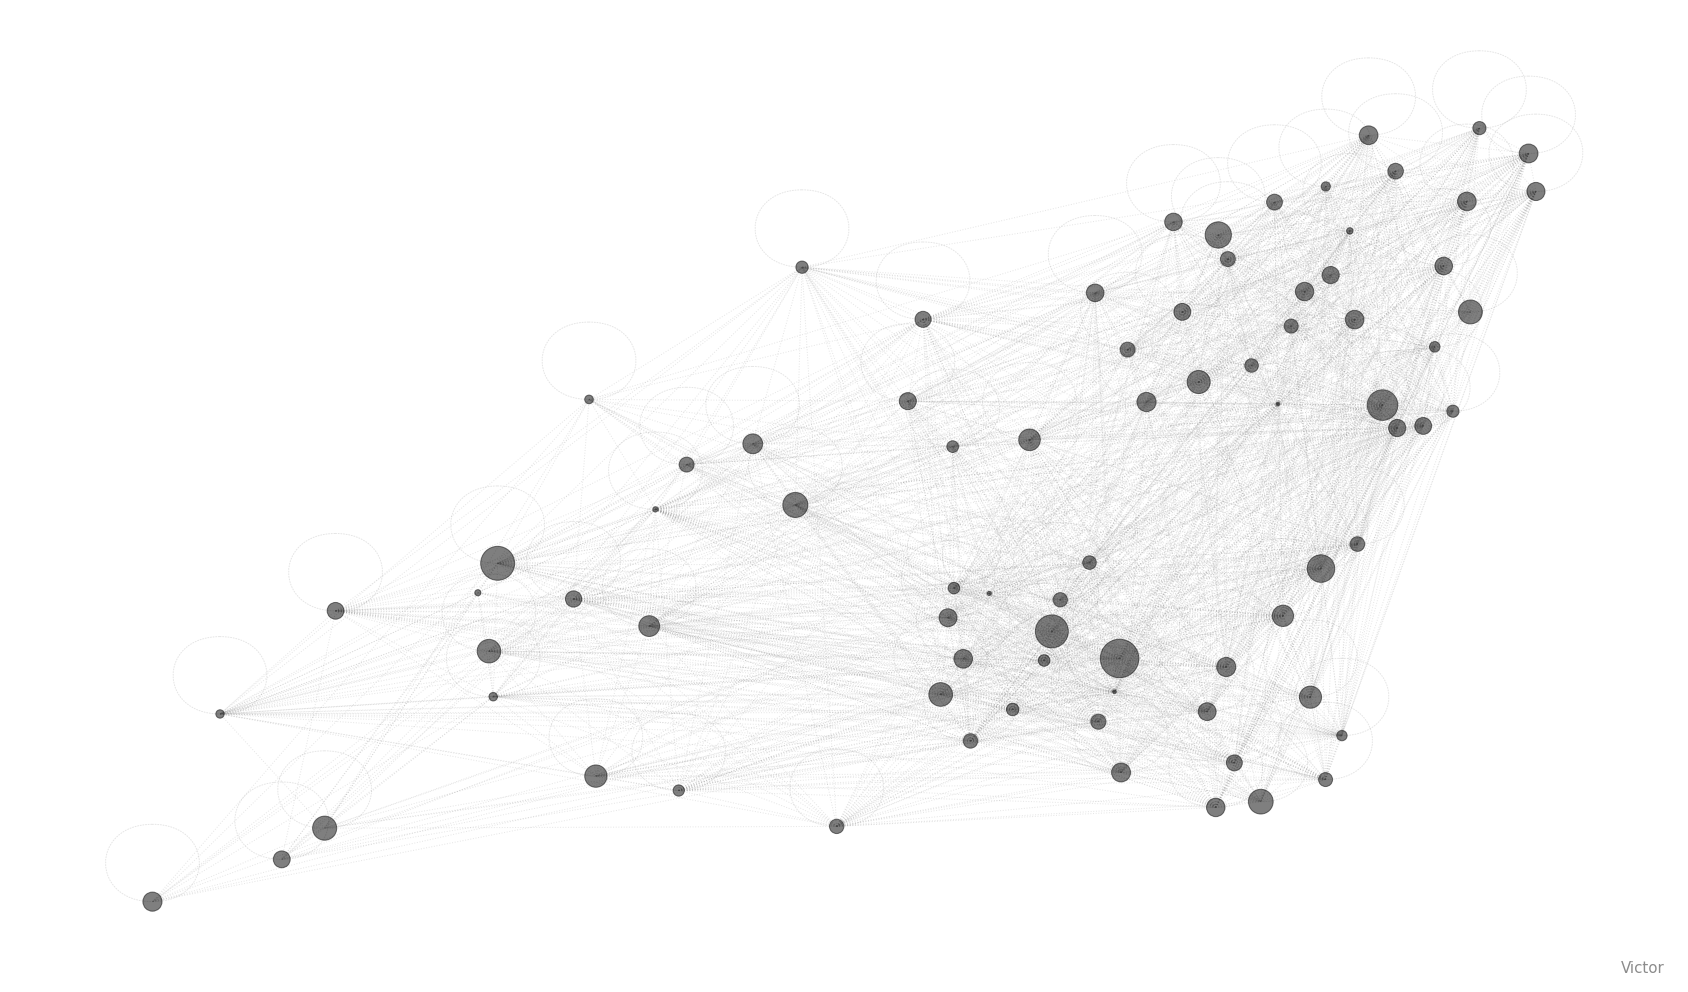

In [34]:

def bike_network(df, node_position_df=None, draw_a_graph=False):

    G = nx.from_pandas_edgelist(df, 'start_station_id', 'end_station_id', edge_attr=['diff_time', 'distance'])

    edge_traffic = dict(collections.Counter(zip(df['start_station_id'].to_list(), df['end_station_id'].to_list())))
    nx.set_edge_attributes(G, edge_traffic, "edge_traffic")

    edge_features_df = df[["start_station_id", "end_station_id", "distance", "diff_time"]]
    edge_features_df = edge_features_df.groupby(["start_station_id", "end_station_id"], as_index=False).mean()
    distance_dict = {(row["start_station_id"], row["end_station_id"]): row["distance"]
                     for _, row in edge_features_df.iterrows()}
    duration_dict = {(row["start_station_id"], row["end_station_id"]): row["diff_time"]
                     for _, row in edge_features_df.iterrows()}
    nx.set_edge_attributes(G, distance_dict, "distance")
    nx.set_edge_attributes(G, duration_dict, "duration")

    # Positions
    stantions = node_positions(df) if node_position_df is None else node_position_df
    pos = stantions.to_dict()['pos']

    node_traffic = dict(collections.Counter((df['start_station_id'].to_list() + df['end_station_id'].to_list())))

    # Map "pos" atribute to nodes from pos dict
    mean_lng, std_lng = -74.04599297457915, 0.015399007166101202
    mean_lat, std_lat = 40.73090132373397, 0.013028667667883737
    for node, position in pos.items():
        try:
            G.nodes[node]['name'] = node
            G.nodes[node]['pos'] = position
            G.nodes[node]['lng'], G.nodes[node]['lat'] = G.nodes[node]['pos']
            G.nodes[node]['pos'] = ((G.nodes[node]['lng'] - mean_lng) / std_lng,
                                    (G.nodes[node]['lat'] - mean_lat) / std_lat)
            G.nodes[node]['lng_scaled'], G.nodes[node]['lat_scaled'] = G.nodes[node]['pos']
            G.nodes[node]['traffic'] = node_traffic[node]
            G.nodes[node]['area'] = node[:2]
        except KeyError:
            pass

    # Draw
    if draw_a_graph:

        # Figure
        fig, ax = plt.subplots(figsize=(30,18))

        node_size = [x/2 for x in node_traffic.values()]
        nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos'), node_color='black', alpha=0.5, node_size=node_size)
        nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.2, arrows=False)
        ax.axis('off')

        ax.text(0.99, 0.01, 'Victor',
                verticalalignment='bottom',
                horizontalalignment='right',
                transform=ax.transAxes,
                color='grey',
                fontsize=15,
                alpha = 0.9)
        
    return G
    
G = bike_network(df_2021, node_position_df=node_position_df, draw_a_graph=True)


# Preliminary network analysis

## Basic Network Statistics

In [35]:
def networkStats(G):
    """
    This function prints the basic properties of the City bike network.
    """
    print(nx.info(G))
    density = nx.density(G)
    print("Network density:", density)
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    #print(G.nodes['Kamppi (M)'])

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G) # Compute eigenvector centrality

    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

networkStats(G)

Graph with 80 nodes and 1910 edges
Network density: 0.6044303797468354
Triadic closure: 0.7064756317689531

Top 5 nodes by degree:

('JC066', 72)
('JC008', 71)
('JC005', 70)
('JC009', 69)
('HB105', 66)

Top 5 nodes by betweenness centrality:

('JC005', 0.020614746258744897)
('JC009', 0.020464392180876714)
('JC066', 0.015064119381835144)
('JC008', 0.015003135593781749)
('JC056', 0.0143138330986665)


## MapPlot

In [36]:
def mapPlot(df, node_position_df=None, display_map=True):

    df_stations = node_positions(df) if node_position_df is None else node_position_df.copy()

    node_traffic = dict(collections.Counter((df['start_station_id'].to_list() + df['end_station_id'].to_list())))

    df_stations['freq'] = [node_traffic[n] for n in df_stations.index]
    #print(df_stations.head(), df_stations.isna().sum(), len(df_stations))
    df_stations["freq_adj"] = df_stations['freq']/(df_stations['freq'].median()/3)
    df_stations.fillna(1, inplace=True)
    df_stations.dropna(inplace=True)

    # Map
    hel_map = folium.Map([40.734791, -74.038773], zoom_start=13) # 参数是latitude, longitude in order!
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    # Maker name list (freq list)
    maker_names = df_stations.freq.to_list()

    for index, row in df_stations.iterrows():
        folium.CircleMarker(location=[row['lat'], row['lng']],
                            radius=row["freq_adj"],
                            popup=str(row['freq']), # 这个是Maker的名字
                            color="#eab544",
                            fill_color="#eab544",
                            ).add_to(hel_map)
    
    if display_map:
        display(hel_map)


mapPlot(df_2021, node_position_df=node_position_df, display_map=True)

## heatMapPlot

In [37]:
def heatMapPlot(df, node_position_df=None):
    """
    This function prints an interactive heatmap by destination locations for a given year.
    """

    df_stations = node_positions(df) if node_position_df is None else node_position_df.copy()

    node_traffic = dict(collections.Counter((df['start_station_id'].to_list() + df['end_station_id'].to_list())))

    df['freq']= df.start_station_id.map(node_traffic)

    # Map
    hel_map = folium.Map([40.734791, -74.038773], zoom_start=13)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    stationArr = df[['start_lat', 'start_lng']].to_numpy()
    hel_map.add_child(plugins.HeatMap(stationArr, radius=15))

    display(hel_map)

heatMapPlot(df_2021, node_position_df=node_position_df)

# Network Centrality Measures

## Degree Centrality

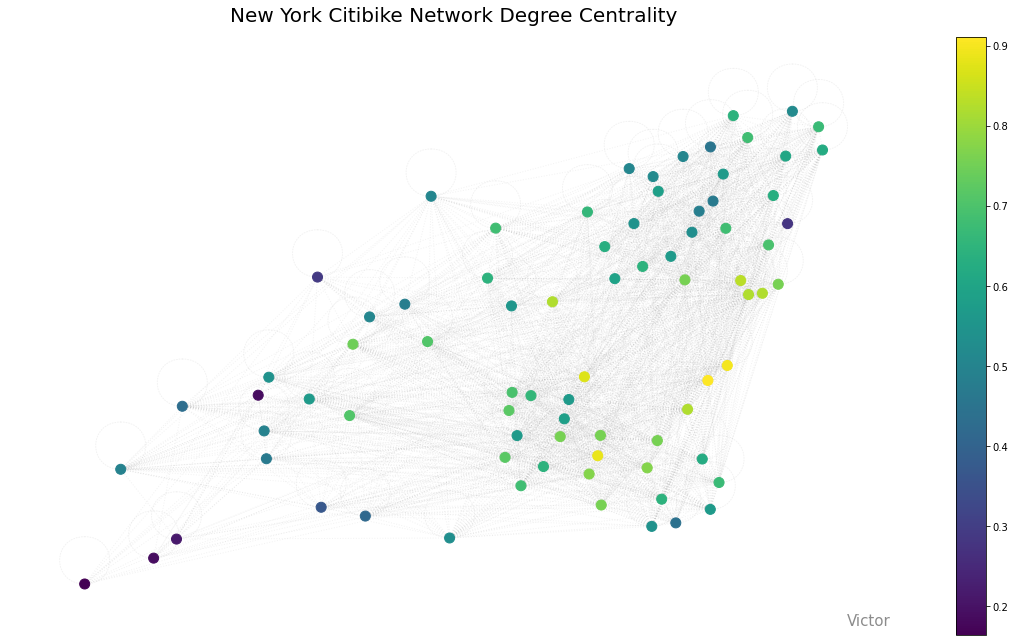

In [38]:
def centralityDegree(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 100)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('New York Citibike Network Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'Victor',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


centralityDegree(G)

### Interactive Version

In [39]:
def centralityDegreeInteractive(G):
    """
    This function plots an interactive network with colorcoded node degrees.
    """
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        opacity=0.4,
        line=dict(width=0.5, color='#888', dash='dot'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Blues',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(thickness=15,title='Node Connections',xanchor='left',titleside='right'),
            line_width=1))

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('Number of connections: '+str(len(adjacencies[1])))

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    width=1000,
                    height=600, 
                    title='New York Citibike Network 2022 Jan',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    paper_bgcolor='rgba(255,255,255,0)',
                    plot_bgcolor='rgba(255,255,255,1)',
                    annotations=[ dict(
                        text="New York",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 )],
                    xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                    yaxis=dict(showgrid=True, zeroline=False, showticklabels=True))
                    )

    fig.show()

centralityDegreeInteractive(G)

### Centrality distribution

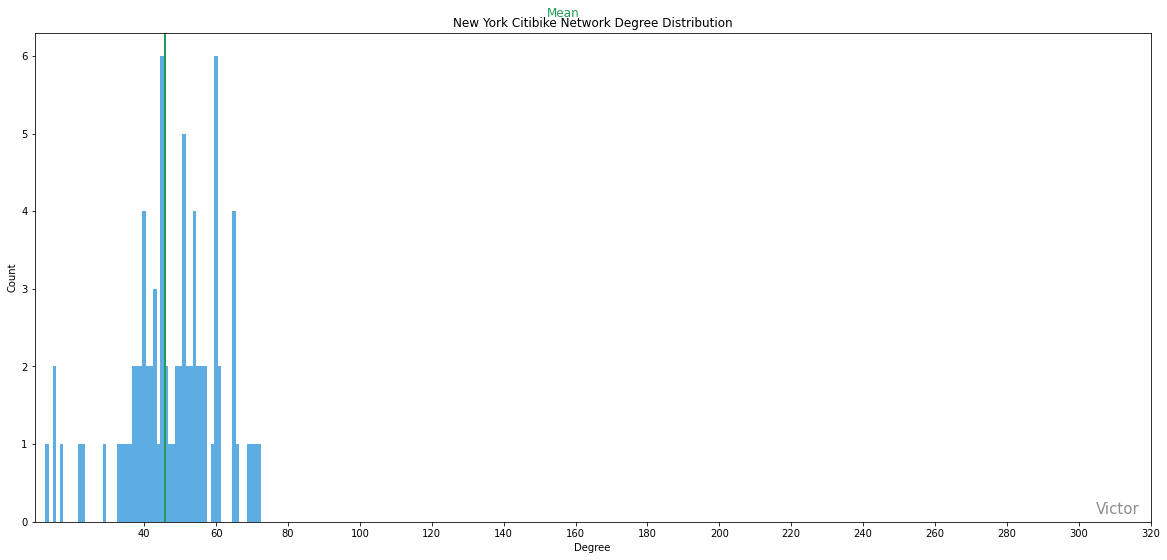

In [40]:
def centralityDegreeDist(G):
    """
    Centrality degree distribution
    """
    # Degree
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    # Figure
    fig, ax = plt.subplots(figsize=(20,9))
    plt.bar(deg, cnt, width=1, color=BLUE)
    plt.axvline(x = sum(deg)/len(deg), color=GREEN, linestyle='-', linewidth=2) # Degree Mean
    #plt.axvline(x = np.median(deg), color="blue", linestyle='-', linewidth=1) # Degree Median

    # Labeling
    plt.title("New York Citibike Network Degree Distribution")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.text(x= 152,y=6.5, s="Mean", color = GREEN, fontsize= 12)
    ax.set_xticks(range(40,340,20))

    # Watermark
    ax.text(0.99, 0.01, 'Victor',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
centralityDegreeDist(G)

In [41]:
# 也就是说大部分都是40-70的degree

## Betweenness Centrality

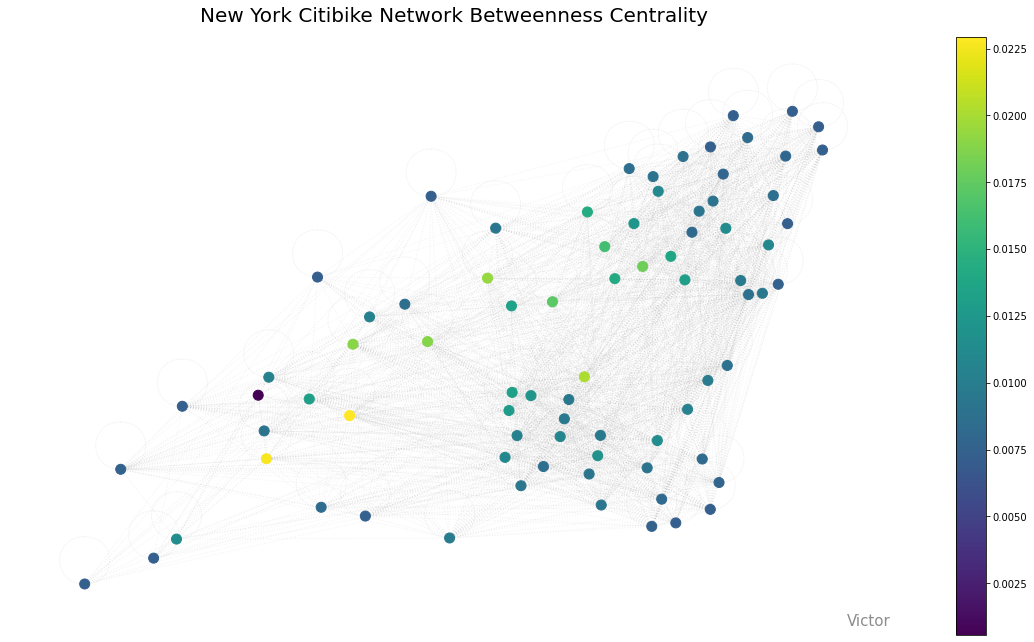

In [42]:
def centralityBetweenness(Graph, weight="distance"): 
    """
    This function plots the city bike network betweenes centrality
    """
    G = Graph.copy(as_view=False)
        
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    betweenness = nx.betweenness_centrality(G, weight=weight)
    node_color = [betweenness[i] for i in betweenness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color) - (sum(node_color)/len(node_color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 100)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('New York Citibike Network Betweenness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'Victor',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


centralityBetweenness(G)

## Closeness Centrality

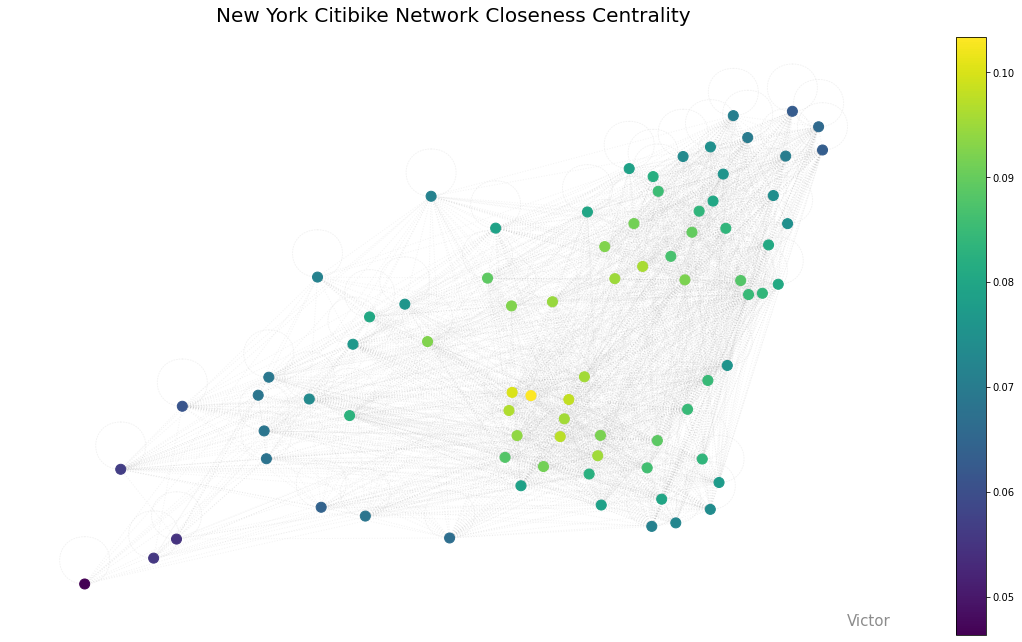

In [43]:
def centralityCloseness(G, distance="duration"):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    closeness = nx.closeness_centrality(G, distance=distance)
    node_color = [closeness[i] for i in closeness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 100)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('New York Citibike Network Closeness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'Victor',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


centralityCloseness(G)

## Eigenvector centrality

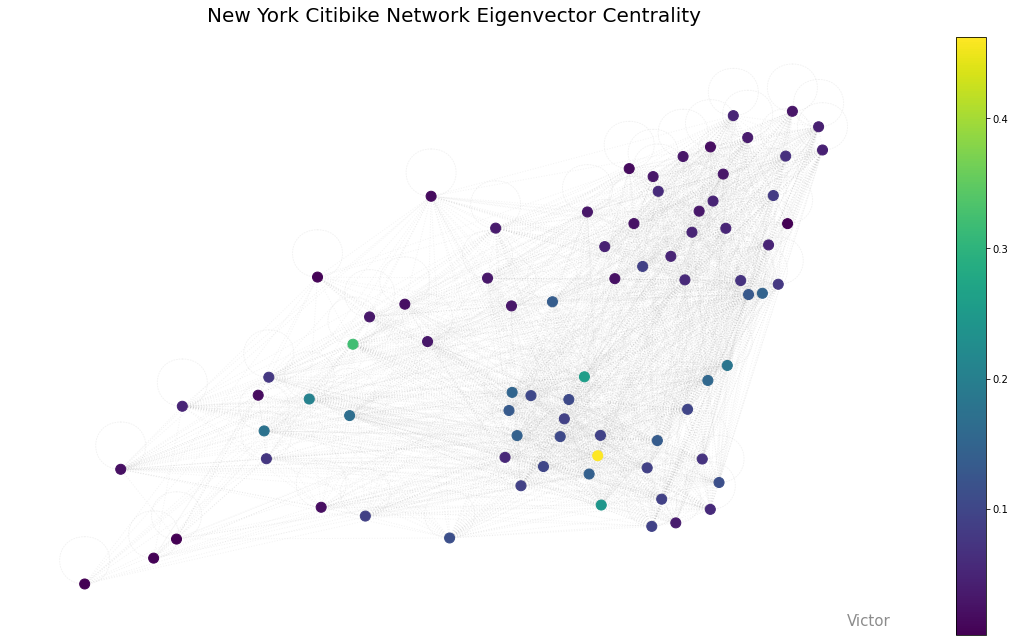

In [44]:
def centralityEigenvector(G):
    """
    This function plots the city bike network Eigenvector centrality
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    eigenvector = nx.eigenvector_centrality(G, max_iter=6000, weight="edge_traffic")
    node_color = [eigenvector[i] for i in eigenvector.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 100)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('New York Citibike Network Eigenvector Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'Victor',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


centralityEigenvector(G)

## PageRank

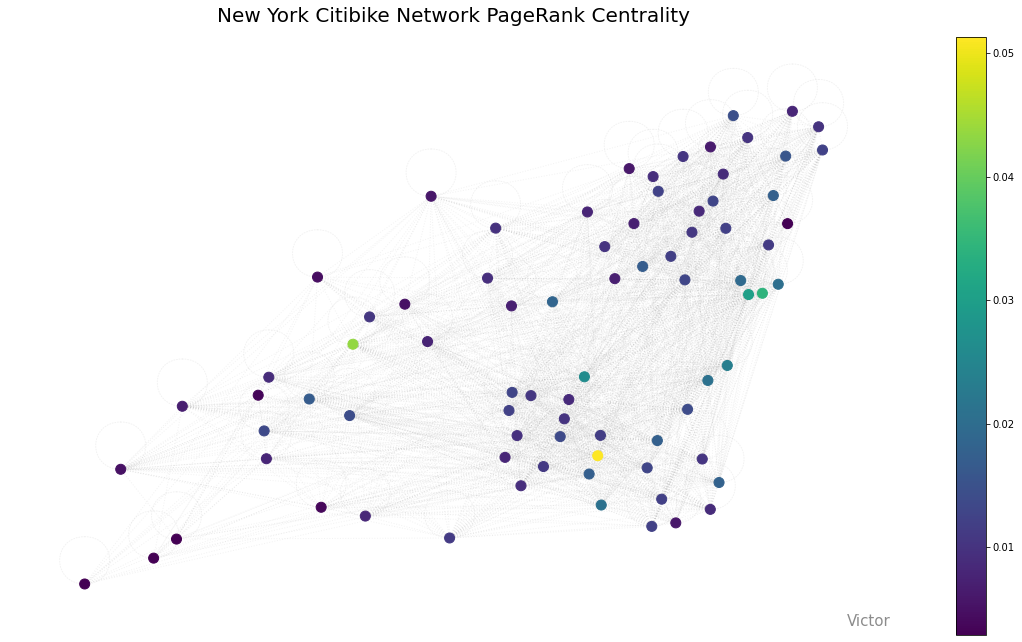

In [45]:
def centralityPageRank(G):
    """
    This function plots the city bike network nodes by PageRank
    """

    # Phagerank
    phagerank = nx.algorithms.link_analysis.pagerank_alg.pagerank(G, weight="edge_traffic")
    node_color = [phagerank[i] for i in phagerank.keys()]

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Color Scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos'), node_color=node_color, cmap="viridis", alpha=1, node_size= 100)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('New York Citibike Network PageRank Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'Victor',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

centralityPageRank(G)

# Community Detection

## Combo Method

In [46]:
!pip install pycombo

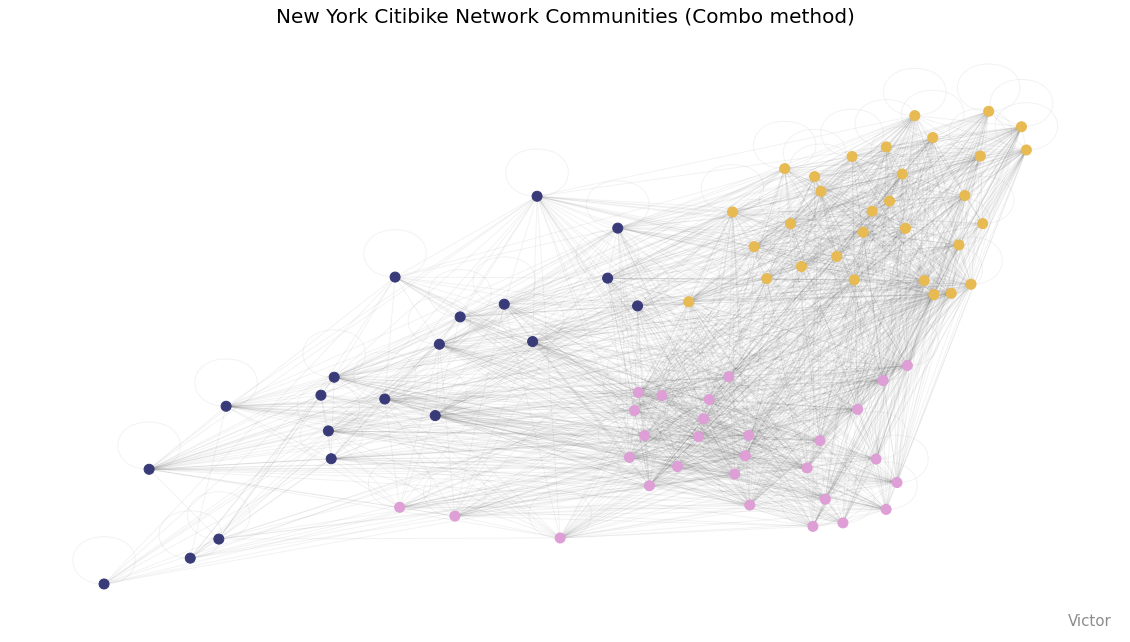

In [47]:
import pycombo

def communityCombo(G, max_communities=3):
    """
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Partition
    partition, modularity = pycombo.execute(
        G, return_modularity=True, modularity_resolution= 1,  
        weight="edge_traffic", max_communities=max_communities, random_seed=1)

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition.keys(), node_size=100, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.05)

    # Labeling Axes
    ax.set_title('New York Citibike Network Communities (Combo method)', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'Victor',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()

communityCombo(G)

## Louvain Method

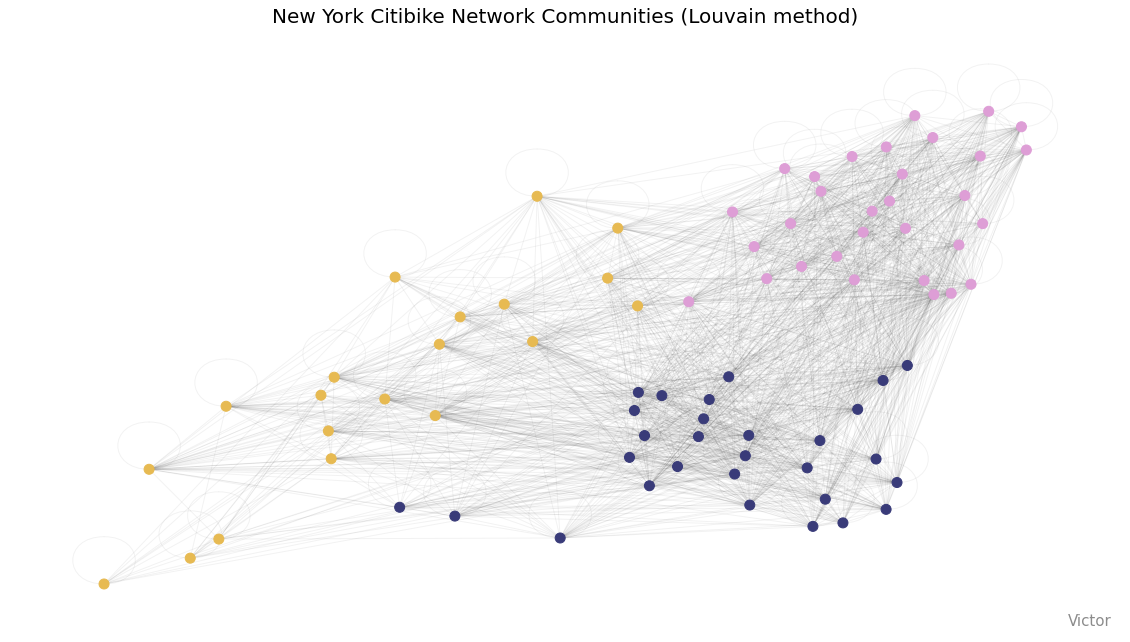

In [48]:
def communityLouvain(G):
    """
    This function applies the Louvain method for community detection on the City bike network.
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute Louvain method
    partition = community_louvain.best_partition(G, resolution=0.95, random_state=1, weight="edge_traffic")

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition.keys(), node_size=100, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.05)

    # Labeling Axes
    ax.set_title('New York Citibike Network Communities (Louvain method)', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'Victor',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
communityLouvain(G)

## Fluid Communities Method


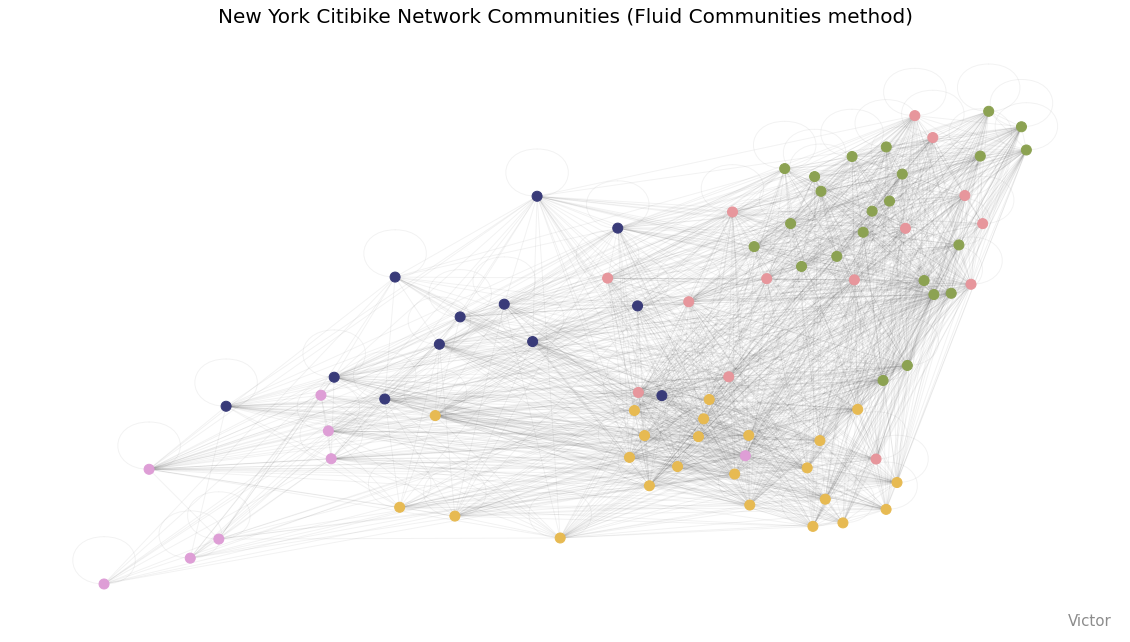

In [49]:
def communityFluid(G, k=5):
    """
    This function applies the Fluid Communities method for community detection on the City bike network.
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute Fluid method
    communities = nx.algorithms.community.asyn_fluid.asyn_fluidc(
        G, k=k, max_iter=10000, seed=1)
    
    # Assigning each node to its cluster
    partition = {}
    for idx, val in enumerate(communities):
        for k in val:
            partition[k] = idx

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition.keys(), node_size=100, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.05)

    # Labeling Axes
    ax.set_title('New York Citibike Network Communities (Fluid Communities method)', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, 'Victor',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
communityFluid(G)

# Time analysis

GitHub: [link to code](https://github.com/brieglhostis/NewYorkCitiBikesAnalysis)

Streamlit: [link to dashboard](https://share.streamlit.io/brieglhostis/newyorkcitibikesanalysis/main/dashboard.py)

In [50]:

def get_most_central_nodes(G, k=10):

    # centrality = nx.algorithms.link_analysis.pagerank_alg.pagerank(G, weight="diff_time")
    centrality = nx.eigenvector_centrality(G, max_iter=6000, weight="duration")
    top_nodes = sorted(centrality, key=lambda x: centrality[x], reverse=True)[:k]
    top_nodes_dict = {node: centrality[node] for node in top_nodes}

    return top_nodes_dict

get_most_central_nodes(G)


{'HB105': 0.19922736405055602,
 'HB408': 0.19345665168711335,
 'JC005': 0.14442099005076928,
 'JC008': 0.17334065533670953,
 'JC009': 0.22387826684416345,
 'JC011': 0.15700237134835543,
 'JC013': 0.14606348193431634,
 'JC032': 0.17869560634726875,
 'JC056': 0.14562071602694504,
 'JC098': 0.14902041503158836}